<a href="https://colab.research.google.com/github/hila-chefer/Transformer-Explainability/blob/main/Transformer_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer Interpretability Beyond Attention Visualization**

In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2


/home/lthpc/.conda/envs/NBEye_image_classification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Imagenet class indices to names
#%%capture
CLS2IDX = {0: 'benign',1:'malignant',2:'premalignant'}

In [5]:
from ViT.ViT_LRP import vit_large_patch16_224 as vit_LRP
from ViT.ViT_explanation_generator import LRP
#@title Perform thresholding on the relevance (using Otsu's method)
use_thresholding =  False#@param {type:"boolean"}
# initialize ViT pretrained
model = vit_LRP(pretrained=False, num_classes=3).cuda()

# replace your finetuned model
model_dir='./models/vit_large_patch16_224_model_best.pth'

checkpoint = torch.load(model_dir)['model']
new_model_dict = {k.replace('module.', ''): v for k, v in checkpoint.items() }
msg = model.load_state_dict(new_model_dict)
model.cuda()
model.eval()
attribution_generator = LRP(model)

print(msg)

<All keys matched successfully>


In [6]:
# from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
import PIL
import torch.nn as nn
import codecs

normalize = transforms.Normalize(mean = [0.50351185, 0.30116007, 0.20442231], std = [0.2821921, 0.22173707, 0.17406568])
transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=PIL.Image.BICUBIC),
        # transforms.CenterCrop((image_size,image_size)),
        transforms.ToTensor(),
        normalize,
    ])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    
    cam = cam / np.max(cam)
    return cam


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =   vis
    vis =  np.uint8(vis*255)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

/home/lthpc/.conda/envs/NBEye_image_classification/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Top 3 classes:
	2 : premalignant		value = 2.913	 prob = 98.2%
	0 : benign      		value = -1.407	 prob = 1.3%
	1 : malignant   		value = -2.375	 prob = 0.5%


(-0.5, 223.5, 223.5, -0.5)

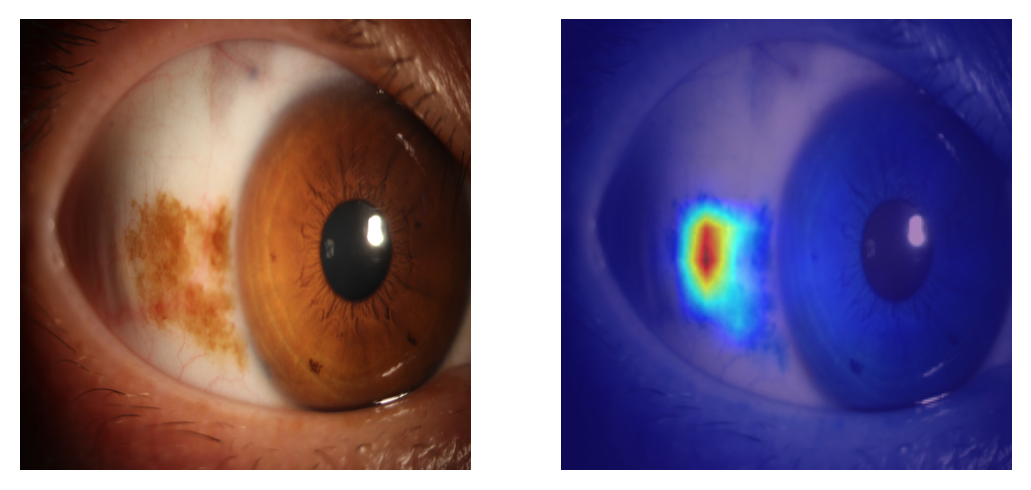

In [7]:
import os
root_dir = './example_img/'
image_name = 'example_oremalignant.jpg'
name, _ = os.path.splitext(image_name)

image = Image.open(root_dir + image_name)
resize_image = image.resize((512,512),Image.LANCZOS)
transform_image = transform(image)
use_thresholding = False

# fig, axs = plt.subplots(1, 4)
fig, axs = plt.subplots(1,2,dpi=200)
axs[0].imshow(resize_image)
axs[0].axis('off')

output = model(transform_image.unsqueeze(0).cuda())
prob = torch.softmax(output, dim=1)

print_top_classes(output)

# the predicted class
cate1 = generate_visualization(transform_image)
resize_image.save(root_dir + name + '_resized.tiff') 
plt.imsave(root_dir + name + '_热图.tiff', cate1)

axs[1].imshow(cate1)
axs[1].axis('off')
